# SQL Order of Operations, Window Functions (RANK and DENSE_RANK)

In [ ]:
!wget https://github.com/gt-cse-6040/bootcamp/raw/main/SQL/syllabus/university.db

In [ ]:
import pandas as pd
from pprint import pprint, pformat

import sqlite3
conn=sqlite3.connect('university.db')


<u>**Order of Operations**</u>

The SQL query engine executes a query differently than we write it. 

We write it more like a sentence / how we'd describe what we want.

**Select** _columns_ <br>
**From** _table_ <br>
**Where** _condition_ <br>
**Group by**  _column(s)_ <br>
**Having** _condition_<br>
**Order by**  _column(s)_<br>
**Limit** _condition(s)_

### The SQL query engine on the other hand builds it from the inside out. 

It starts with **FROM** table(s) and **JOIN**(s) and assembles the **base/starting** dataset.

&nbsp;&nbsp;&nbsp;&nbsp; Then it filters out rows as requested in the **WHERE** clause, 
    
&nbsp;&nbsp;&nbsp;&nbsp; Puts them in buckets according to the **GROUP BY** clause, 
    
&nbsp;&nbsp;&nbsp;&nbsp; Filters the groups according to the **HAVING** clause,
    
&nbsp;&nbsp;&nbsp;&nbsp; Picks the fields in the **SELECT** statement,
    
&nbsp;&nbsp;&nbsp;&nbsp; Gets them all in order with the **ORDER BY** clause,
    
&nbsp;&nbsp;&nbsp;&nbsp; And then applies any **LIMIT**s to the number of rows returned.

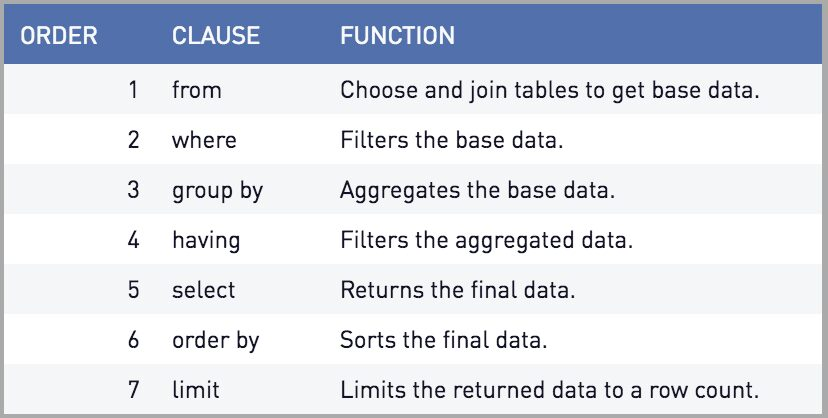<br>https://www.sisense.com/blog/sql-query-order-of-operations/

<u>_Side note_ <br></u>
In most SQL languages, this order of operations is why you can't reference an alias in the **WHERE** clause that you wrote in the select statement because to the query engine, it hasn't gotten to the select statement yet to know you renamed a column. <br><br>
SQLite allows the use of aliases not following the order of operations in a way that other SQL languages do not.<br><br>
Also, SQLite does not care about white space in any way, unlike Python. It is completely up to you on what format is easiest to you.

# Window functions

SQLite window functions are based on what PostgreSQL offers. Other SQL languages have additional functions and / or can be implemented slightly differently.
<br><br>Overall, they can be grouped into these domains:<br><br>
**Ranking Functions:** ROW_NUMBER(), RANK(), DENSE_RANK(), NTILE()

**Aggregate Functions:** SUM(), AVG(), MIN(), MAX(), COUNT()

**Value Functions:** LEAD(), LAG(), FIRST_VALUE(), LAST_VALUE(), NTH_VALUE()

**Windowing Functions:** ROWS BETWEEN, RANGE BETWEEN

**Statistical Functions:** PERCENT_RANK(), CUME_DIST()

*    https://www.sqlite.org/windowfunctions.html

## SQL works in `set-based` approach. 

You group / aggregate over all of the data in a table, or set. 

Sometimes you need SQL to manipulate the data into smaller sets than the entire query results. 

`Window functions` allow you to achieve that by creating `_windows_` of data by defining partitions to break up the query results in one step, rather than using an iterative approach and reading the query results row by agonizing row, which is usually terribly inefficient. 



## Suppose we wanted to return the top 5 scholarships by term.

If we didn't have windows functions, we would have to self join using sub queries and that would not be efficient in a computational aspect because it would have to scan each row individually and compare it to the other rows.

## Note that we are including the below query simply to show the complexity.

## We are NOT working through it in detail, and we leave this for students to do, if they are so inclined.

In [ ]:
#self join example
def SelfJoinSubQueries() -> str:
  return f"""
            SELECT sc1.scholarship_term, sc1.scholarship_code, sc1.scholarship_count
            FROM (
                    SELECT
                        ss.scholarship_term,
                        ss.scholarship_code,
                        COUNT(*) AS scholarship_count
                    FROM student_main sm
                        INNER JOIN student_key sk 
                                ON sm.student_id = sk.student_id
                        INNER JOIN student_scholarship ss 
                                ON sk.finance_id = ss.finance_id
                        INNER JOIN scholarship_crosswalk sc 
                                ON sc.scholarship_code = ss.scholarship_code
                    GROUP BY ss.scholarship_term, ss.scholarship_code
                ) sc1
            WHERE 
                (
                SELECT COUNT(*) 
                FROM (
                        SELECT
                            ss.scholarship_code,
                            COUNT(*) AS scholarship_count
                        FROM student_main sm
                            INNER JOIN student_key sk 
                                    ON sm.student_id = sk.student_id
                            INNER JOIN student_scholarship ss 
                                    ON sk.finance_id = ss.finance_id
                        WHERE ss.scholarship_term = sc1.scholarship_term
                        GROUP BY ss.scholarship_code
                      ) sc2
                WHERE sc2.scholarship_count > sc1.scholarship_count
                ) < 5
            order by scholarship_term, scholarship_count desc;
"""
display(pd.read_sql(SelfJoinSubQueries(),conn))

### If we use a window function, it allows SQLite to run one query, and then displays the results for us in the way we requested.

Our query counts the number of scholarships each term and then shows the top five most popular ones.

#### We can achieve that by using the **RANK()** window function. 

&nbsp;&nbsp;&nbsp;&nbsp; It adds a rank, or something analogous to a dataframe index, that we can now reference in the query for filtering. 

&nbsp;&nbsp;&nbsp;&nbsp; In the case of ties, **RANK()** skips the next number (or numbers if there are multiple ties) and continues with numbering.

#### The **OVER** keyword is where we define our _window_ for the data. 

&nbsp;&nbsp;&nbsp;&nbsp; If the **OVER()** parameter is left blank, it assumes the window is the entire dataset. 

&nbsp;&nbsp;&nbsp;&nbsp; In this case we're wanting to break down the data by scholarship_term, so we have **OVER(PARITION BY scholarship_term ORDER BY Count(*) DESC)** so we sort our count from most to least.

### We will show how to do this in 2 steps.

&nbsp;&nbsp;&nbsp;&nbsp; First we will show the **WINDOW()** function, and how it works.

&nbsp;&nbsp;&nbsp;&nbsp; Then we will use our **WINDOW()** function within a query, to meet the exercise requirements.

In [ ]:
def windowfunction() -> str:
  return f"""
    SELECT
        ss.scholarship_term,
        ss.scholarship_code,
        COUNT(*) AS scholarship_count,
        
        RANK() OVER (PARTITION BY ss.scholarship_term ORDER BY COUNT(*) DESC) AS rnk
    
    FROM student_main sm
        INNER JOIN student_key sk 
                    ON sm.student_id = sk.student_id
        INNER JOIN student_scholarship ss 
                    ON sk.finance_id = ss.finance_id
        INNER JOIN scholarship_crosswalk sc 
                    ON sc.scholarship_code = ss.scholarship_code
    GROUP BY ss.scholarship_term, ss.scholarship_code
  """
display(pd.read_sql(windowfunction(),conn))

#### We then encapsulate that entire query into a SUBQUERY, and filter the top five through the WHERE clause on the outside. 

In [ ]:
def windowfunctionexample() -> str:
  return f"""
SELECT *
FROM (
        SELECT
            ss.scholarship_term,
            ss.scholarship_code,
            COUNT(*) AS scholarship_count,
            
            RANK() OVER (PARTITION BY ss.scholarship_term ORDER BY COUNT(*) DESC) AS Rank
            
        FROM student_main sm
            INNER JOIN student_key sk 
                    ON sm.student_id = sk.student_id
            INNER JOIN student_scholarship ss 
                    ON sk.finance_id = ss.finance_id
            INNER JOIN scholarship_crosswalk sc 
                    ON sc.scholarship_code = ss.scholarship_code
        GROUP BY ss.scholarship_term, ss.scholarship_code
    ) ranked
WHERE ranked.Rank <= 5;
  """
display(pd.read_sql(windowfunctionexample(),conn))

#### Note that in the above results, the last two rows, for the `scholarship_term` `202408`, have the same `COUNT`, so their `RANK` is the same.

#### What happens to rows `AFTER` rows that are tied?

#### The answer to this question illustrates the difference between `RANK` and `DENSERANK`.

The `RANK()` function will return the next available number, after the ties are accounted for.

See the example below.

In [ ]:
#Rank where it shows that two is skipped
def Rank() -> str:
  return f"""
            SELECT
                ss.Scholarship_term,
                ss.Scholarship_code,
                COUNT(*) AS Scholarship_count,
                
                RANK() OVER (PARTITION BY ss.scholarship_term ORDER BY COUNT(*) DESC) AS Rank
                
            FROM student_main sm
                INNER JOIN student_key sk 
                        ON sm.student_id = sk.student_id
                INNER JOIN student_scholarship ss 
                        ON sk.finance_id = ss.finance_id
                INNER JOIN scholarship_crosswalk sc 
                        ON sc.scholarship_code = ss.scholarship_code
            WHERE scholarship_term = '201605'
            GROUP BY ss.scholarship_term, ss.scholarship_code
  """
display(pd.read_sql(Rank(),conn))

The `DenseRank()` function on the other hand, does not skip any numbers, after the ties are accounted for.

See the example below.

In [ ]:
#Dense Rank where two is not skipped
def DenseRank() -> str:
  return f"""
    SELECT
        ss.scholarship_term,
        ss.scholarship_code,
        COUNT(*) AS scholarship_count,
        
        DENSE_RANK() OVER (PARTITION BY ss.scholarship_term ORDER BY COUNT(*) DESC) AS DenseRank
        
    FROM student_main sm
        INNER JOIN student_key sk 
            ON sm.student_id = sk.student_id
        INNER JOIN student_scholarship ss 
            ON sk.finance_id = ss.finance_id
        INNER JOIN scholarship_crosswalk sc 
            ON sc.scholarship_code = ss.scholarship_code
    WHERE scholarship_term = '201605'
    GROUP BY ss.scholarship_term, ss.scholarship_code
  """
display(pd.read_sql(DenseRank(),conn))

### Something similar to the rank / dense rank is the <b>ROW_NUMBER()</b> window function. 

It too adds an incremented column, but in the case of <b>ROW_NUMBER()</b> it just adds a sequential row number based on the position of the record in the dataset rather than a ranking tied to a specific value.

You could use <b>ROW_NUMBER()</b> to achieve the previous query and filter by that instead of the ranking. 

The downside to using row number is if there are ties, and you ask for the top 3 things, but there's four rows with the top 3 numbers, you will lose the 4th row.

In [ ]:
#RowNumber
def RowNumber() -> str:
  return f"""
            SELECT
                    ss.scholarship_term,
                    ss.scholarship_code,
                    COUNT(*) AS scholarship_count,
                    
                    ROW_NUMBER() OVER (
                        PARTITION BY ss.scholarship_term 
                        ORDER BY COUNT(*) DESC
                    ) AS RowNum
                    
                FROM student_main sm
                    INNER JOIN student_key sk 
                        ON sm.student_id = sk.student_id
                    INNER JOIN student_scholarship ss 
                        ON sk.finance_id = ss.finance_id
                    INNER JOIN scholarship_crosswalk sc 
                        ON sc.scholarship_code = ss.scholarship_code
                WHERE scholarship_term = '201605'
                GROUP BY ss.scholarship_term, ss.scholarship_code
  """
display(pd.read_sql(RowNumber(),conn))

In [ ]:
#Row Number to give the top three rows, but it only returns the top TWO values
def RowNumber() -> str:
  return f"""
            SELECT *
            FROM (
                    SELECT
                            ss.scholarship_term,
                            ss.scholarship_code,
                            COUNT(*) AS scholarship_count,
                            
                            ROW_NUMBER() OVER (
                                PARTITION BY ss.scholarship_term 
                                ORDER BY COUNT(*) DESC
                            ) AS RowNum
                            
                        FROM student_main sm
                            INNER JOIN student_key sk 
                                ON sm.student_id = sk.student_id
                            INNER JOIN student_scholarship ss 
                                ON sk.finance_id = ss.finance_id
                            INNER JOIN scholarship_crosswalk sc 
                                ON sc.scholarship_code = ss.scholarship_code
                        WHERE scholarship_term = '201605'
                        GROUP BY ss.scholarship_term, ss.scholarship_code
                    ) ranked
            WHERE RowNum <= 3;
  """
display(pd.read_sql(RowNumber(),conn))

**ADDITIONAL READING**<br>
_This book is focused specifically on Microsoft SQL / T-SQL, but the book goes into great detail about the history and philosophy behind SQL itself and window functions. The syntax between T-SQL and SQLite is almost identical in this case._ <br>
T-SQL Window Functions: For data analysis and beyond, 2nd Edition <br>
https://learning.oreilly.com/library/view/t-sql-window-functions/9780135861554/
<br><br>
_His book_ T-SQL Fundamentals, 4th Edition _also goes into great detail about all things SQL._ <br>
https://learning.oreilly.com/library/view/t-sql-fundamentals-4th/9780138101930/ <br><br>

DataLemur is also an excellent resource for learning PostgreSQL, which is what SQLite is modeled on.<br>
https://datalemur.com/sql-tutorial/sql-aggregate-window-functions <br>
https://datalemur.com/sql-tutorial/query-order-of-execution
